<img src='https://drive.google.com/uc?export=view&id=1i_XBoCPReEtySdjypk36ux3qIAwufet5' height=400 >


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
google_stock_data = pd.read_csv('../input/google-stock-prediction/GOOG.csv')
google_stock_data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [4]:
google_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   float64
 13  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.7+ KB


In [5]:
google_stock_data = google_stock_data[['date','open','close']] # Extracting required columns
google_stock_data['date'] = pd.to_datetime(google_stock_data['date'].apply(lambda x: x.split()[0])) # Selecting only date
google_stock_data.set_index('date',drop=True,inplace=True) # Setting date column as index
google_stock_data.head()

,open,close
date,,
2016-06-14,716.48,718.27
2016-06-15,719.00,718.92
2016-06-16,714.91,710.36
2016-06-17,708.65,691.72
2016-06-20,698.77,693.71


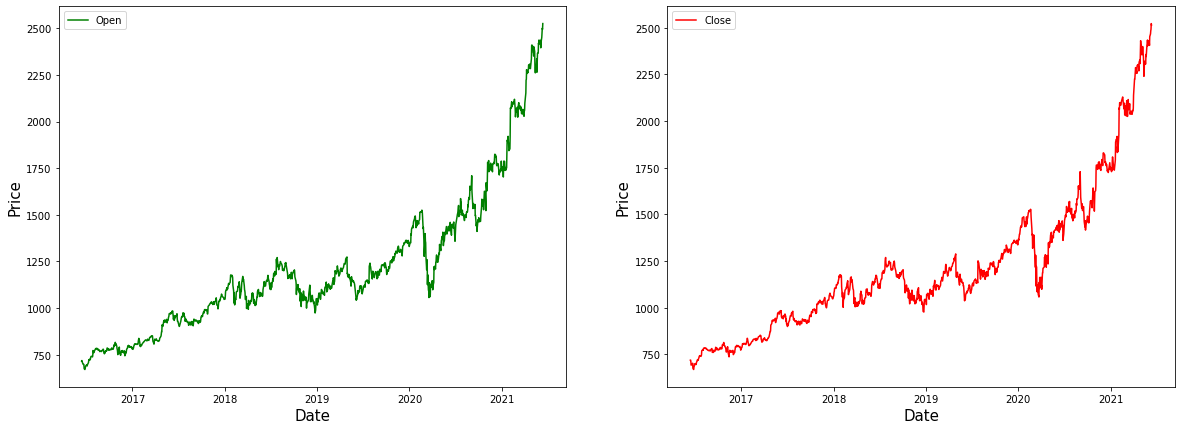

In [6]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(google_stock_data['open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()

ax[1].plot(google_stock_data['close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()

fg.show()

# Data Pre-Processing

In [7]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
google_stock_data[google_stock_data.columns] = MMS.fit_transform(google_stock_data)

In [8]:
google_stock_data.shape

(1258, 2)

In [9]:
training_size = round(len(google_stock_data) * 0.80) # Selecting 80 % for training and 20 % for testing
training_size

1006

In [10]:
train_data = google_stock_data[:training_size]
test_data  = google_stock_data[training_size:]

train_data.shape, test_data.shape

((1006, 2), (252, 2))

In [11]:
# Function to create sequence of data for training and testing

def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))


In [12]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [13]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((956, 50, 2), (956, 2), (202, 50, 2), (202, 2))

# Creating LSTM model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [15]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10600     
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
30/30 [==============================] - 6s 30ms/step - loss: 0.0101 - mean_absolute_error: 0.0701 - val_loss: 0.0215 - val_mean_absolute_error: 0.1284
Epoch 2/80
30/30 [==============================] - 0s 8ms/step - loss: 8.7195e-04 - mean_absolute_error: 0.0230 - val_loss: 0.0046 - val_mean_absolute_error: 0.0548
Epoch 3/80
30/30 [==============================] - 0s 8ms/step - loss: 5.4049e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0035 - val_mean_absolute_error: 0.0474
Epoch 4/80
30/30 [==============================] - 0s 8ms/step - loss: 5.4485e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0037 - val_mean_absolute_error: 0.0488
Epoch 5/80
30/30 [==============================] - 0s 8ms/step - loss: 5.1508e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0032 - val_mean_absolute_error: 0.0451
Epoch 6/80
30/30 [==============================] - 0s 8ms/step - loss: 4.8673e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0054 - val_mean_absolute_error: 0.0611
Epoch 7

In [17]:
test_predicted = model.predict(test_seq)
test_predicted[:5]

array([[0.48932385, 0.49351725],
       [0.4956513 , 0.50008285],
       [0.5007923 , 0.50547576],
       [0.51826614, 0.5209031 ],
       [0.52780724, 0.53116405]], dtype=float32)

In [18]:
test_inverse_predicted = MMS.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[1578.1672, 1582.9153],
       [1589.8978, 1595.0836],
       [1599.429 , 1605.0785],
       [1631.824 , 1633.6707],
       [1649.5125, 1652.6876]], dtype=float32)

# Visualizing predicted and actual data

In [19]:
# Merging actual and predicted data for better visualization

gs_slic_data = pd.concat([google_stock_data.iloc[-202:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=google_stock_data.iloc[-202:].index)], axis=1)

In [20]:
gs_slic_data[['open','close']] = MMS.inverse_transform(gs_slic_data[['open','close']]) # Inverse scaling

In [21]:
gs_slic_data.head()

,open,close,open_predicted,close_predicted
date,,,,
2020-08-24,1593.98,1588.20,1578.167236,1582.915283
2020-08-25,1582.07,1608.22,1589.897827,1595.083618
2020-08-26,1608.00,1652.38,1599.428955,1605.078491
2020-08-27,1653.68,1634.33,1631.823975,1633.670654
2020-08-28,1633.49,1644.41,1649.512451,1652.687622


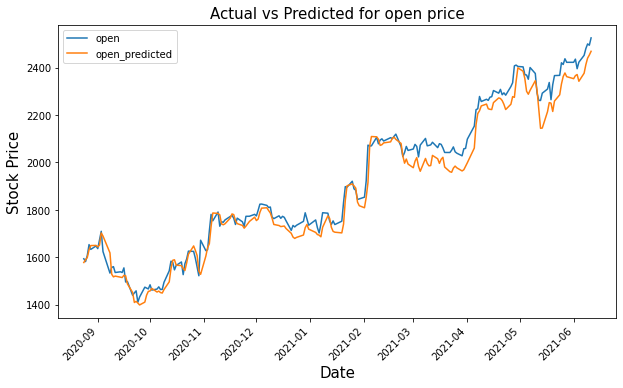

In [22]:
gs_slic_data[['open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

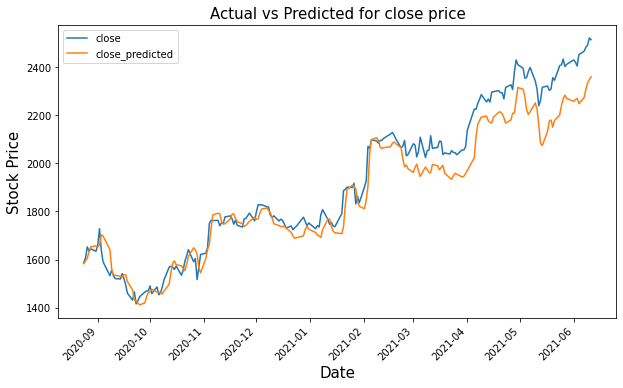

In [23]:
gs_slic_data[['close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

# Predicting upcoming 10 days

In [24]:
# Creating a dataframe and adding 10 days to existing index 

gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))


In [25]:
gs_slic_data['2021-06-09	':'2021-06-16']

,open,close,open_predicted,close_predicted
2021-06-09,2499.50,2491.40,2439.688232,2334.860107
2021-06-10,2494.01,2521.60,2452.823486,2347.956543
2021-06-11,2524.92,2513.93,2468.412354,2359.697998
2021-06-12,NaN,NaN,NaN,NaN
2021-06-13,NaN,NaN,NaN,NaN
2021-06-14,NaN,NaN,NaN,NaN
2021-06-15,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN


In [26]:
upcoming_prediction = pd.DataFrame(columns=['open','close'],index=gs_slic_data.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [27]:
curr_seq = test_seq[-1:]

for i in range(-10,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)


In [28]:
upcoming_prediction[['open','close']] = MMS.inverse_transform(upcoming_prediction[['open','close']])

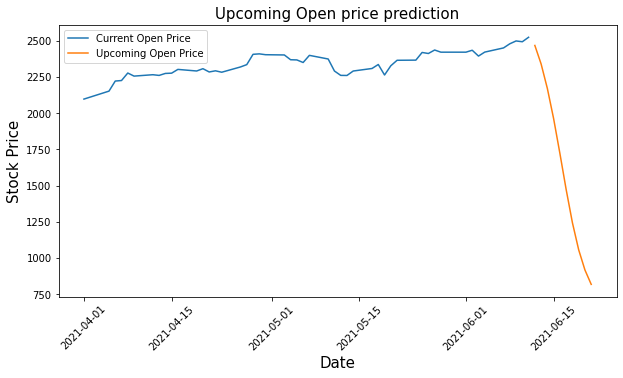

In [29]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'open'],label='Current Open Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'open'],label='Upcoming Open Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming Open price prediction',size=15)
ax.legend()
fg.show()

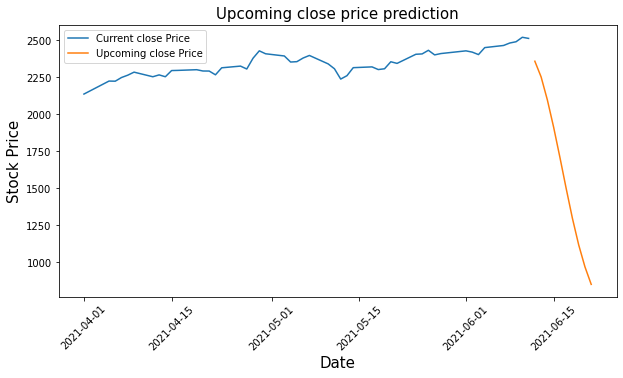

In [30]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fg.show()